DEV PATEL 23AIML047

## Manufacturing Quality Control With Control Charts
Problem:
A factory tracks defect rates on an assembly line and needs to detect shifts in quality.
- Ingest daily sample defect counts and sample sizes
- Compute daily defect proportion p,build controlcharts(p-chart) with 3sigma limits.
- Use hypothesis tests to flag days where defect proportion exceeds expected bounds.
- Analyze run length and propose corrective actions based on detected shifts.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


It generate 60 dates starting from January 1, 2024. For each day, it assigns a
random sample size (between 80 and 120 items). Then, assuming a true defect rate of 5%, it uses a binomial distribution to simulate how many items are defective each day. And then it stores this data in a DataFrame and calculates the daily defect rate by dividing the number of defects by the sample size.




In [ ]:
np.random.seed(42)
days=pd.date_range(start='2024-01-01',periods=60)
sample_size=np.random.randint(80,120,size=60) #daily sample size
true_defect_rate=0.05
defect_counts=np.random.binomial(sample_size,true_defect_rate)
df=pd.DataFrame({'date':days,'sample_size':sample_size,'defect_count':defect_counts})
df['Defect_rate']=df['defect_count']/df['sample_size']
df.head()

,date,sample_size,defect_count,Defect_rate
0,2024-01-01,118,5,0.042373
1,2024-01-02,108,9,0.083333
2,2024-01-03,94,6,0.063830
3,2024-01-04,87,3,0.034483
4,2024-01-05,100,5,0.050000


A p-chart(proportion chart) is used in statistical quality control to monitor the proportion of defective units in a process when sample size may vary from day to day.

This value (p_bar) acts like a baseline or centerline on the p-chart. The same value is added as a new column in the DataFrame so it can be used in later calculations like setting control limits.

In [ ]:
#overall average defect rate
p_bar=df['defect_count'].sum()/df['sample_size'].sum()

#Control limits(3 sigma)
df['p_bar']=p_bar
df.head()

,date,sample_size,defect_count,Defect_rate,p_bar
0,2024-01-01,118,5,0.042373,0.052011
1,2024-01-02,108,9,0.083333,0.052011
2,2024-01-03,94,6,0.063830,0.052011
3,2024-01-04,87,3,0.034483,0.052011
4,2024-01-05,100,5,0.050000,0.052011


In [ ]:
df['UCL']=p_bar+3*np.sqrt(p_bar*(1-p_bar)/df['sample_size']) #upper control limit
df['LCL']=p_bar-3*np.sqrt(p_bar*(1-p_bar)/df['sample_size']) #lower control limit
df.head()

,date,sample_size,defect_count,Defect_rate,p_bar,UCL,LCL
0,2024-01-01,118,5,0.042373,0.052011,0.113336,-0.009313
1,2024-01-02,108,9,0.083333,0.052011,0.116112,-0.012089
2,2024-01-03,94,6,0.063830,0.052011,0.120720,-0.016697
3,2024-01-04,87,3,0.034483,0.052011,0.123430,-0.019407
4,2024-01-05,100,5,0.050000,0.052011,0.118626,-0.014604


In [ ]:
df['LCL']=df['LCL'].clip(lower=0) #LCL can't be negative
df.head()

,date,sample_size,defect_count,Defect_rate,p_bar,UCL,LCL
0,2024-01-01,118,5,0.042373,0.052011,0.113336,0.0
1,2024-01-02,108,9,0.083333,0.052011,0.116112,0.0
2,2024-01-03,94,6,0.063830,0.052011,0.120720,0.0
3,2024-01-04,87,3,0.034483,0.052011,0.123430,0.0
4,2024-01-05,100,5,0.050000,0.052011,0.118626,0.0


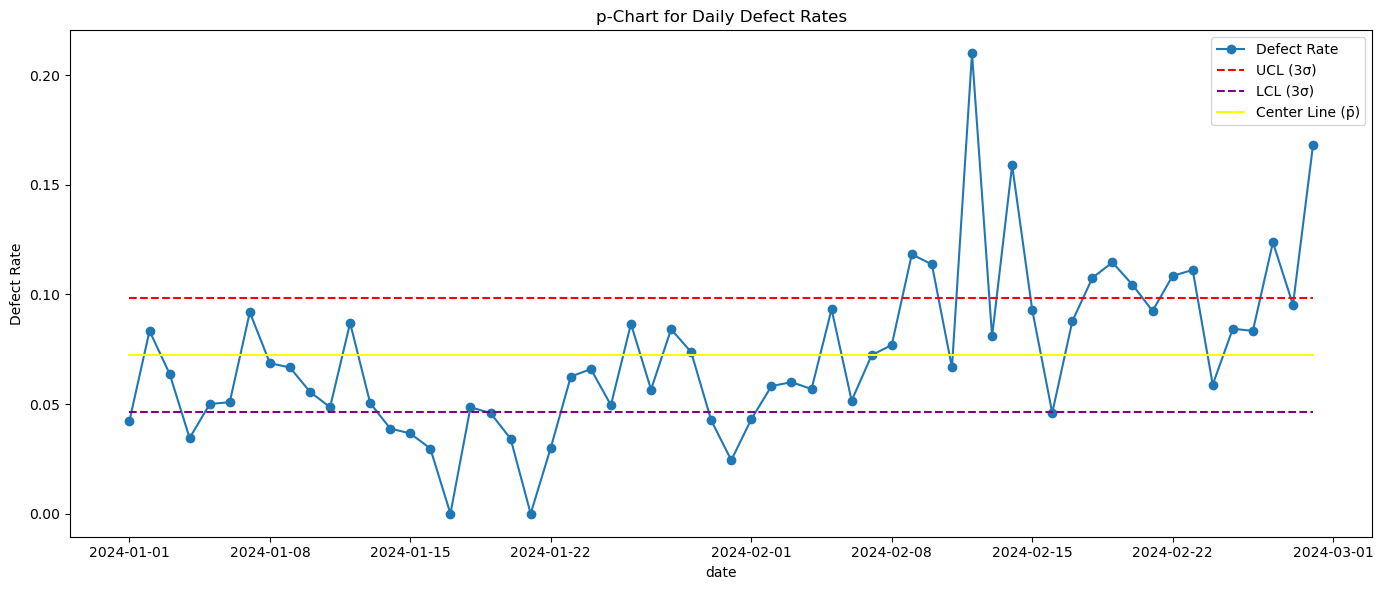

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['Defect_rate'], marker='o', label='Defect Rate')
plt.plot(df['date'], df['UCL'], linestyle='--', color='red', label='UCL (3σ)')
plt.plot(df['date'], df['LCL'], linestyle='--', color='purple', label='LCL (3σ)')
plt.plot(df['date'], df['p_bar'], linestyle='-', color='yellow', label='Center Line (p̄)')
plt.title("p-Chart for Daily Defect Rates")
plt.xlabel('date')
plt.ylabel('Defect Rate')
plt.legend()
plt.tight_layout()
plt.show()

we can use a p-chart, which helps monitor the proportion of defective units over time. By plotting daily defect rates against control limits, the p-chart reveals whether the process is stable or if there are signs of unexpected variation that may require investigation.


## out-of-control Points
we are trying to flag the days where the defect rate is too high or too low- that is,outside the expected control limits on our p-chart

In [ ]:
df['out_of_control']=(df['Defect_rate']>df['UCL'])|(df['Defect_rate']<df['LCL'])
# true- if that day is out of control
# false- if the defect rate is within limits
print(df.head())
print(df[df['out_of_control']][['date','Defect_rate','UCL','LCL']]) # filter out of control=true

        date  sample_size  defect_count  Defect_rate     p_bar       UCL  LCL  \
0 2024-01-01          118             5     0.042373  0.052011  0.113336  0.0   
1 2024-01-02          108             9     0.083333  0.052011  0.116112  0.0   
2 2024-01-03           94             6     0.063830  0.052011  0.120720  0.0   
3 2024-01-04           87             3     0.034483  0.052011  0.123430  0.0   
4 2024-01-05          100             5     0.050000  0.052011  0.118626  0.0   

   out_of_control  
0           False  
1           False  
2           False  
3           False  
4           False  
Empty DataFrame
Columns: [date, Defect_rate, UCL, LCL]
Index: []


## Hypothesis Testing Example(One proportion Z-test)

using hypothesis testing, specifically the One Proportion Z-test, to statistically check whether a specific day's defect rate is significantly higher than usual.



In [ ]:
from statsmodels.stats.proportion import proportions_ztest
#understand most defect are above the 0.5 per threshold
#test if last day's defect rate is significantly higher then average
last=df.iloc[-1]
count=last['defect_count']
nobs=last['sample_size']
stat,pval=proportions_ztest(count,nobs,value=p_bar,alternative='larger')
if pval<0.05:
  print("Reject the null hypothesis")
else:
  print("Fail to reject the null hypothesis")

Fail to reject the null hypothesis


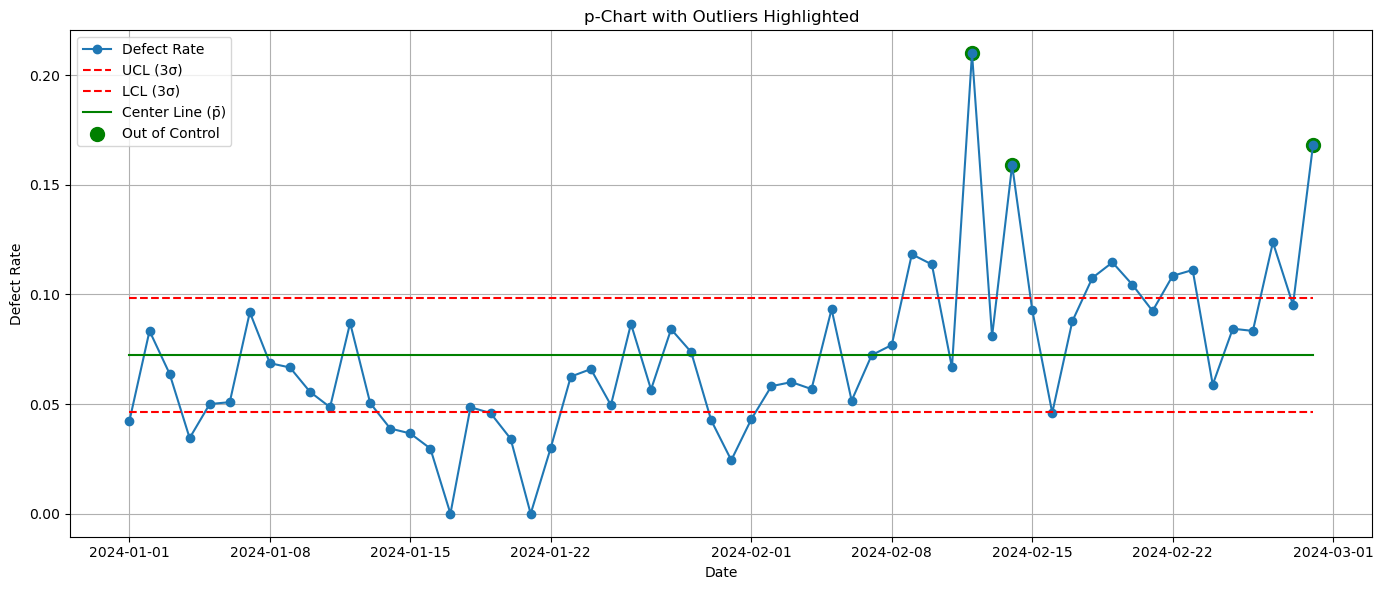

In [ ]:
#mark control points on chart
plt.figure(figsize=(14,6))
plt.plot(df['date'],df['Defect_rate'],marker='o',label='Defect Rate')
plt.plot(df['date'],df['UCL'],linestyle='--',color='red',label='UCL (3σ)')
plt.plot(df['date'],df['LCL'],linestyle='--',color='red',label='LCL (3σ)')
plt.plot(df['date'],df['p_bar'],linestyle='-',color='green',label='Center Line (p̄)')

#highlight points
out=df[df['out_of_control']]
plt.scatter(out['date'],out['Defect_rate'],color='green',s=100,label='Out of Control')
plt.title("p-Chart with Outliers Highlighted")
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## process shift
A process shift means that the behaviour or performance of a manufacturing or production process change over time- usally in a way that affect quality.
It's like when something in the process goes wrong and causes the defect rate,output,or measurements to move away from normal.

When a process starts performing fidderently than usual-often worse - and can lead to more defects or off-target results.

## Everyday Analogy
Think of a coffee machine that usually fills cups with 200 ml of coffe.Suddenly, one day it starts filling 220 ml.that's a shift in the process -even though the machine is still working,it's no longer performing the same way.

## In quality control terms
A process shift often means that the process avg increase or decreases unexpectedly.

In [ ]:
#Introduce a shift in the defect rate on day 35
df.loc[35:,'defects']=np.random.binomial(df.loc[35:,'sample_size'],0.10) #doubled defect rate
df['defect_rate']=df['defects']/df['sample_size']
df.head()

,date,sample_size,defect_count,Defect_rate,p_bar,UCL,LCL,out_of_control,defects,defect_rate
0,2024-01-01,118,5,0.042373,0.052011,0.113336,0.0,False,NaN,NaN
1,2024-01-02,108,9,0.083333,0.052011,0.116112,0.0,False,NaN,NaN
2,2024-01-03,94,6,0.063830,0.052011,0.120720,0.0,False,NaN,NaN
3,2024-01-04,87,3,0.034483,0.052011,0.123430,0.0,False,NaN,NaN
4,2024-01-05,100,5,0.050000,0.052011,0.118626,0.0,False,NaN,NaN


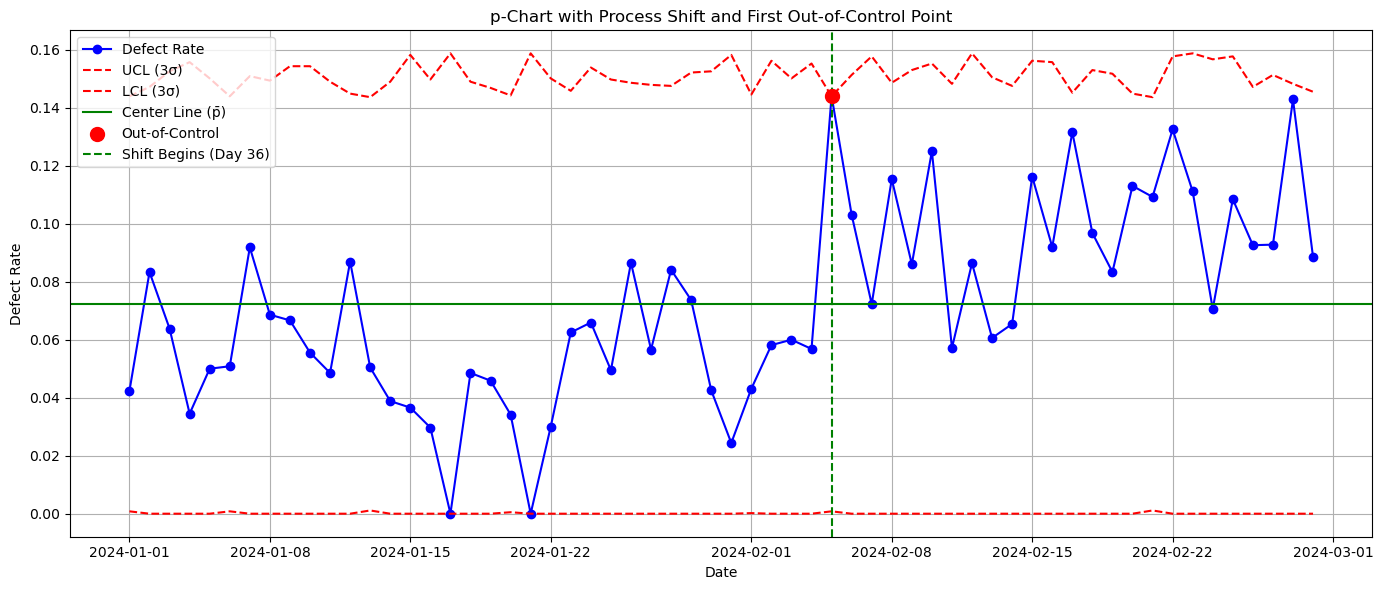

No significant shift detected.


In [ ]:
# Introduce a shift in the defect rate on day 35
df.loc[35:, 'defect_count'] = np.random.binomial(df.loc[35:, 'sample_size'], 0.10) # doubled defect rate
# Recalculate the defect rate based on the potentially shifted defect counts
df['Defect_rate'] = df['defect_count'] / df['sample_size']

# For 10% defect after 35 days
# Recalculate p_bar based on the potentially shifted defect counts
p_bar = df['defect_count'].sum() / df['sample_size'].sum()
df['p_bar'] = p_bar

# Recalculate control limits based on the new p_bar
df['UCL'] = p_bar + 3 * np.sqrt(p_bar * (1 - p_bar) / df['sample_size'])
df['LCL'] = p_bar - 3 * np.sqrt(p_bar * (1 - p_bar) / df['sample_size'])
df['LCL'] = df['LCL'].clip(lower=0)

# flag out of control points (true/false)
df['out_of_control'] = (df['Defect_rate'] > df['UCL']) | (df['Defect_rate'] < df['LCL'])
out_points = df[df['out_of_control']]

plt.figure(figsize=(14, 6))
# Defect Rate line - Use 'date' column for x-axis and 'Defect_rate' for y-axis
# Corrected column name from 'Defect_Rate' to 'Defect_rate'
plt.plot(df['date'], df['Defect_rate'], marker='o', label='Defect Rate', color='blue')

# Control Limits - Use 'date' column for x-axis
plt.plot(df['date'], df['UCL'], 'r--', label='UCL (3σ)')
plt.plot(df['date'], df['LCL'], 'r--', label='LCL (3σ)')

# The horizontal line for p_bar doesn't need 'date' column as it's constant
plt.axhline(p_bar, color='green', linestyle='-', label='Center Line (p̄)')
plt.scatter(df[df['out_of_control']]['date'], df[df['out_of_control']]['Defect_rate'],
            color='red', label='Out-of-Control', zorder=5, s=100)

# Show vertical line for process shift - Need to define shift_day and use 'date' column
# Assuming shift_day is index 35 (the 36th day) based on the shift introduction code
shift_day = 35
plt.axvline(df.loc[shift_day, 'date'], color='green', linestyle='--',label=f'Shift Begins (Day {shift_day + 1})')
plt.title("p-Chart with Process Shift and First Out-of-Control Point")
plt.xlabel("Date")
plt.ylabel("Defect Rate")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
print("No significant shift detected.")

The plot highlights a clear process shift starting on Day 36 (2024-02-05), marked by a vertical purple dashed line. Before this date, defect rates were mostly stable and below the center line. Afterward, defect rates visibly increased, with three red points exceeding the Upper Control Limit (UCL)—indicating out-of-control conditions.

Although the chart output says “No significant shift detected,” the visual evidence clearly shows a deterioration in quality. This inconsistency suggests that corrective action is urgently needed to restore process stability.



##  Run Rules in Quality control
Run rules are additional rules used alongside control limits on control charts(like p chart) to detedct subtle signs that a process might be shifting -even when the points are within control limits.
control limits catch big jumps(like defects suddenly doubling). But run rules catch smaller changes that occur gradually or consistently -before they become big problem.

They are early warning system for quality drift.

Rule 1: If the defect rate on any day goes outside the 3-sigma limits (very far from normal), it’s a clear sign something’s off.

Rule 2: Even if defects aren’t extreme, if 2 out of 3 consecutive days have defect rates beyond the 2-sigma limits (moderately unusual), it suggests the process might be shifting.

Rule 3: If you see a run of 8 or more days all above or all below the average, it means the process has likely changed in a lasting way, not just random ups and downs.


In [ ]:
import numpy as np
import pandas as pd # Added import for pandas

#step 1: Estimate standard deviation for each row
df['sigma']=np.sqrt((df['p_bar']*(1-df['p_bar']))/df['sample_size'])

#step 2
df['Upper_1sigma']=df['p_bar']+df['sigma']
df['Lower_1sigma']=df['p_bar']-df['sigma']
df['Upper_2sigma']=df['p_bar']+(2*df['sigma'])
df['Lower_2sigma']=df['p_bar']-(2*df['sigma'])

#Rule 1
df['Rule1']=(df['Defect_rate']>df['UCL'])| (df['Defect_rate']<df['LCL'])

#Rule 2
rule2_flags=[False]*len(df)
for i in range(2,len(df)):

  upper=(df.loc[i-2:i,'Defect_rate']>df.loc[i-2:i,'Upper_2sigma']).sum()

  lower=(df.loc[i-2:i,'Defect_rate']<df.loc[i-2:i,'Lower_2sigma']).sum()
  rule2_flags[i]=(upper>=2) or(lower>=2)
df['Rule2']=rule2_flags

#Rule 3
df['Above_center']=df['Defect_rate']>df['p_bar']
run_length=[1]
for i in range(1,len(df)):
  if df.loc[i,'Above_center']==df.loc[i-1,'Above_center']:
    run_length.append(run_length[-1]+1)
  else:
    run_length.append(1)
df['Run_length']=run_length
df['Rule3']=(df['Run_length']>=8)

#combine rules
df['Any_rule_violation']=df[['Rule1','Rule2','Rule3']].any(axis=1)

#view violation
violations = df[df['Any_rule_violation']]
print(violations[['date', 'Defect_rate', 'Rule1', 'Rule2', 'Rule3']])

         date  Defect_rate  Rule1  Rule2  Rule3
19 2024-01-20     0.034188  False  False   True
20 2024-01-21     0.000000  False  False   True
21 2024-01-22     0.030000  False  False   True
22 2024-01-23     0.062500  False  False   True
23 2024-01-24     0.065934  False  False   True
24 2024-01-25     0.049505  False  False   True
42 2024-02-12     0.209877   True  False  False
44 2024-02-14     0.158879   True   True  False
59 2024-02-29     0.168142   True  False  False


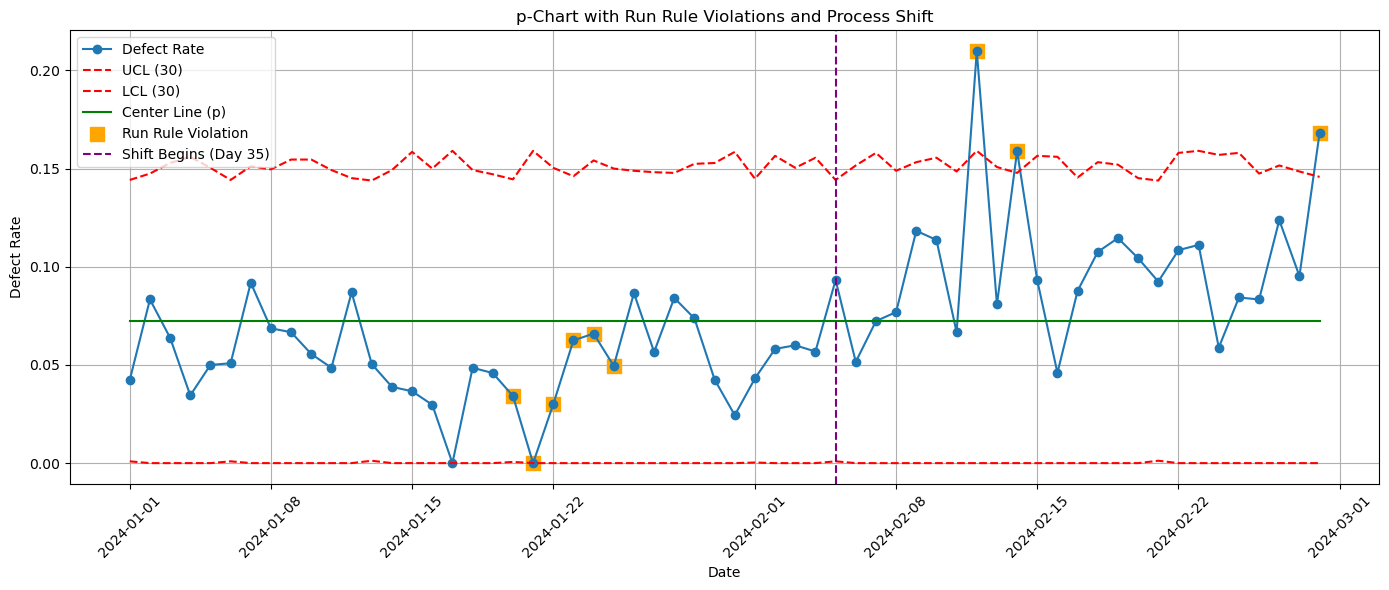

In [ ]:
# Plot with violations highlighted
plt.figure(figsize=(14, 6))

# Main defect rate line
# Corrected column names to 'date' and 'Defect_rate'
plt.plot(df['date'], df['Defect_rate'], marker='o', label='Defect Rate')

# Control limits and center
# Corrected column name to 'date'
plt.plot(df['date'], df['UCL'], linestyle='--', color='red', label='UCL (30)')
plt.plot(df['date'], df['LCL'], linestyle='--', color='red', label='LCL (30)')
# Corrected column name to 'date' for the axhline (though not strictly necessary as p_bar is constant, using date for consistency with other plots)
plt.plot(df['date'], df['p_bar'], linestyle='-', color='green', label='Center Line (p)')


# Highlight violations
# Corrected column names to 'date' and 'Defect_rate'
plt.scatter(violations['date'], violations['Defect_rate'],
color='orange', s=100, marker='s', label='Run Rule Violation')

# Add shift marker
# Corrected column name to 'date'
plt.axvline(df['date'].iloc[35], color='purple', linestyle='--', label='Shift Begins (Day 35)')

# Final touches
plt.title('p-Chart with Run Rule Violations and Process Shift')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This p-Chart shows that before day 35, the defect rate was mostly stable and within control limits, with a few small rule violations. After day 35 (marked by the vertical purple line), there is a clear increase in the defect rate, with several points nearing or exceeding the upper control limit and more frequent rule violations. This indicates a shift in the process, likely due to a change in conditions or quality issues starting from that day.



## What is Process Capability
Process Capability tells us how well a process can produce items within the limits set by customers. It helps answer if the process consistently makes good parts. Two key metrics are Cp and Cpk.
- Cp checks how wide the process spread is compared to the specification limits, but not if it's centered.
- Cpk checks both the spread and whether the process is centered between the limits, giving a better idea of actual performance.

If Cpk < Cp, it means the process is off-center that is, the process average is closer to one of the specification limits rather than centered. This increases the risk of producing defects even if the overall process variability remains the same.


In [ ]:
LSL=0.00
USL=0.08
mu=df['Defect_rate'].mean()
sigma=df['Defect_rate'].std()

cp=(USL-LSL)/(6*sigma)
# Pass the two values as a tuple to the min() function
cpk=min(((USL-mu)/(3*sigma)),((mu-LSL)/(3*sigma)))
print(f"cp={cp:.2f},cpk={cpk:.2f}")

cp=0.36,cpk=0.07


In [ ]:
USL,LSL=0.08,0.02
process_sigma=df['Defect_rate'].std()
cp=(USL-LSL)/(6*process_sigma)
cpk=min(((USL-mu)/(3*sigma)),((mu-LSL)/(3*sigma)))
print(f"cp={cp:.2f},cpk={cpk:.2f}")

cp=0.27,cpk=0.07


This analysis shows that both Cp and Cpk values are low (Cp ≈ 0.36, Cpk ≈ 0.07), which means the process is not capable and needs improvement. The very low Cpk, much smaller than Cp, indicates the process is not centered and is too close to one of the specification limits. Even when the LSL is adjusted to 0.02, the Cp and Cpk remain below 1.0, confirming the process is still far from acceptable performance.






## Bootstapping
Bootstrapping is reshampling technique that involves repeatedly drawing samples with replacement from an original dataset.

This method allows estimation of the sampling distribution of a statistic without relying on the strict assumptions about the underlying population.It is widely used for calculating confidence intervals and assessing the variability of estimates.

In [ ]:
boot_means=[np.mean(np.random.choice(df['Defect_rate'],size=len(df),replace=True))for _ in range(1000)]
ci_lower=np.percentile(boot_means,2.5)
ci_upper=np.percentile(boot_means,97.5)
print(f'The 95% confidence interval is ({ci_lower:.4f},{ci_upper:.4f})')

The 95% confidence interval is (0.0633,0.0819)


By bootstrapping we estimate the 95% confidence interval for the mean defect rate. The result shows that we are 95% confident the true average defect rate lies between 0.0633 and 0.0819. This means the process's average performance is likely within this range, giving us a clearer understanding of its typical defect rate.





## Adding a shaded Confidence Interval band

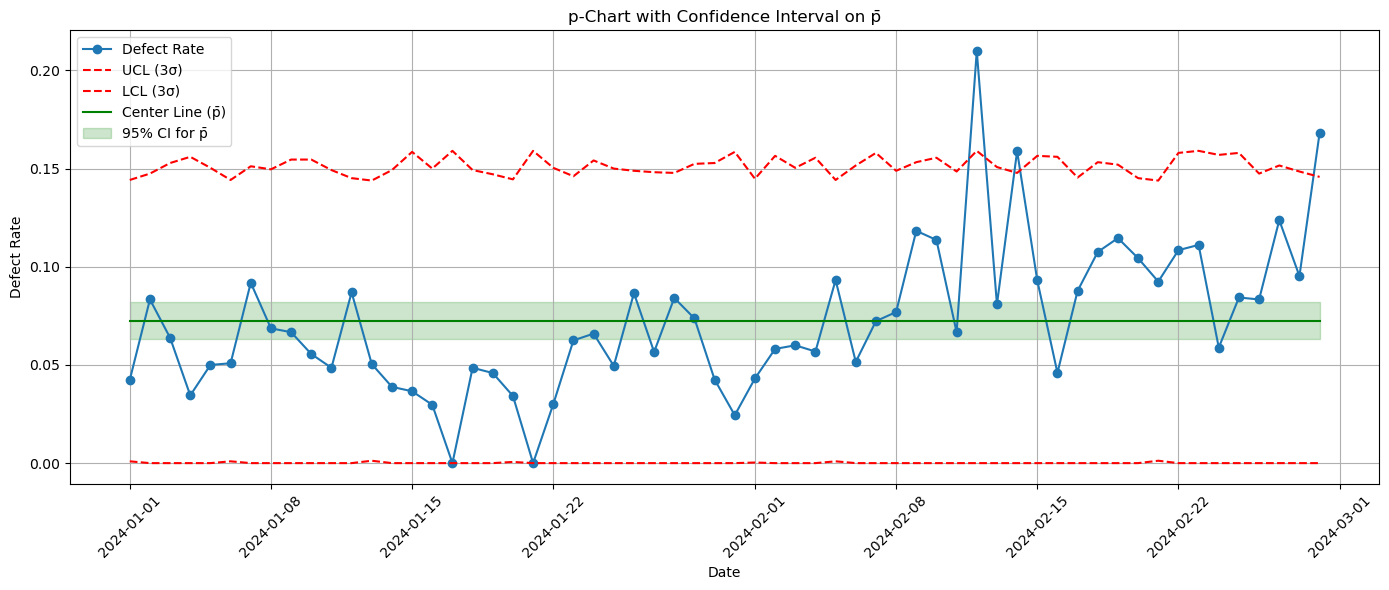

In [ ]:
# Existing chart
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['Defect_rate'], marker='o', label='Defect Rate')
plt.plot(df['date'], df['UCL'], linestyle='--', color='red', label='UCL (3σ)')
plt.plot(df['date'], df['LCL'], linestyle='--', color='red', label='LCL (3σ)')
plt.plot(df['date'], df['p_bar'], linestyle='-', color='green', label='Center Line (p̄)')

# Add this for confidence interval shading
plt.fill_between(
    df['date'], ci_lower, ci_upper,
    color='green', alpha=0.2, label='95% CI for p̄'
)

# Finalize chart
plt.title('p-Chart with Confidence Interval on p̄')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The p-Chart tracks defect rates over time, with control limits and a confidence interval to assess process variations. The green shaded line represents the average proportion of defects, serving as a benchmark for comparison. Some points exceed the upper control limit, indicating potential quality concerns that may require further investigation. Overall, this chart helps ensure defects stay within acceptable limits, supporting process stability and reliability.




## What is Hypothesis Testing over time?
Hypothesis testing over time is a way to check if the daily defect rates in a process are truly changing or just randomly going up and down. Instead of guessing, we use statistical tests to see if there’s a real trend, like a steady increase or improvement. For example, we test a starting assumption that there’s no change, and if the results show otherwise, we can say with confidence that the process is getting better or worse. This helps us track progress and make better decisions.


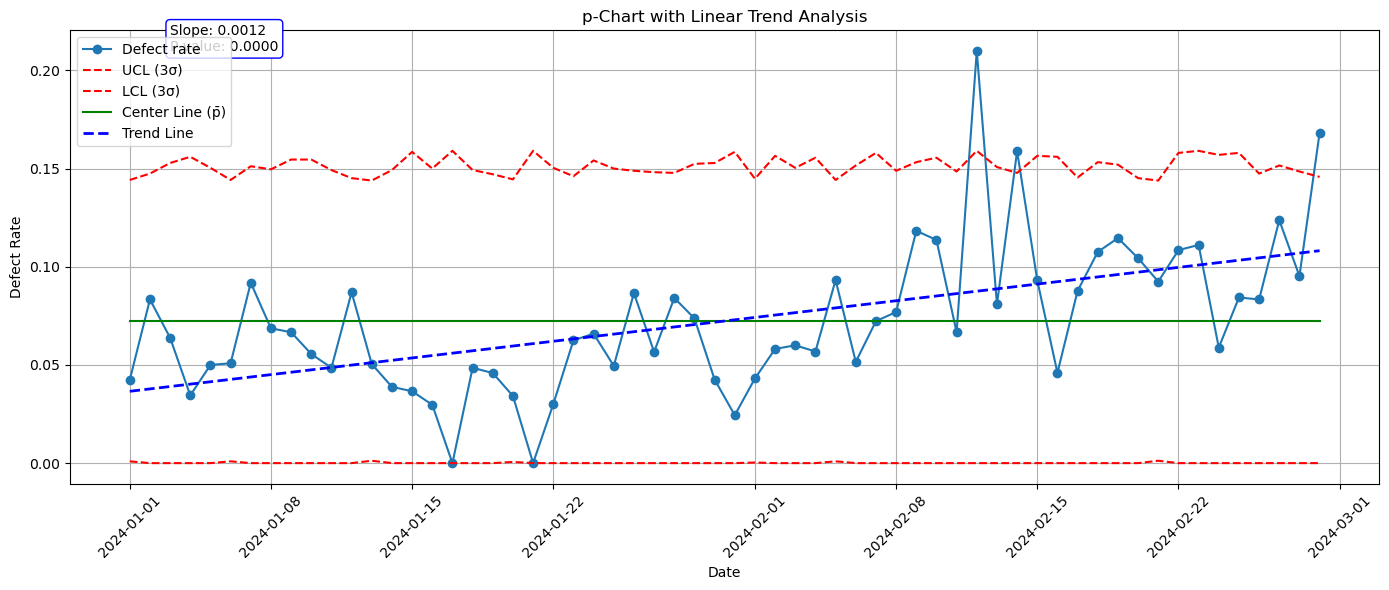

In [ ]:
from scipy.stats import linregress
import pandas as pd

# create Day dataframe
df['Day']=range(1,len(df)+1)
trend_result=linregress(df['Day'],df['Defect_rate'])
slope=trend_result.slope
p_value=trend_result.pvalue
intercept=trend_result.intercept
df['Trend_Line']=intercept+slope*df['Day']

plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['Defect_rate'], marker='o', label='Defect rate')
plt.plot(df['date'], df['UCL'], linestyle='--', color='red', label='UCL (3σ)')
plt.plot(df['date'], df['LCL'], linestyle='--', color='red', label='LCL (3σ)')
plt.plot(df['date'], df['p_bar'], linestyle='-', color='green', label='Center Line (p̄)')
plt.plot(df['date'], df['Trend_Line'], linestyle='--', color='blue', linewidth=2, label='Trend Line')

plt.text(df['date'].iloc[2], max(df['Defect_rate']),
         f"Slope: {slope:.4f}\nP-value: {p_value:.4f}",
         fontsize=10, bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round'))
plt.title('p-Chart with Linear Trend Analysis')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The process seems in control based on control limits, the defect rate is gradually increasing over time. This suggests a hidden issue may be developing in the manufacturing process, and action should be taken before defects rise further or exceed limits.










## CUSUM Chart
A CUSUM chart is a tool used to spot small, steady changes in a process faster than regular p-charts. Instead of showing daily values like defect rates, it adds up the differences from the average over time. If defects are higher than expected, the line goes up, if lower, it goes down, and if things are stable then the line stays near zero. This is useful because p-charts might miss small shifts, but CUSUM can catch them early—before they become big problems. It’s especially helpful when tracking whether the process is slowly getting better or worse, even if control limits aren't crossed.




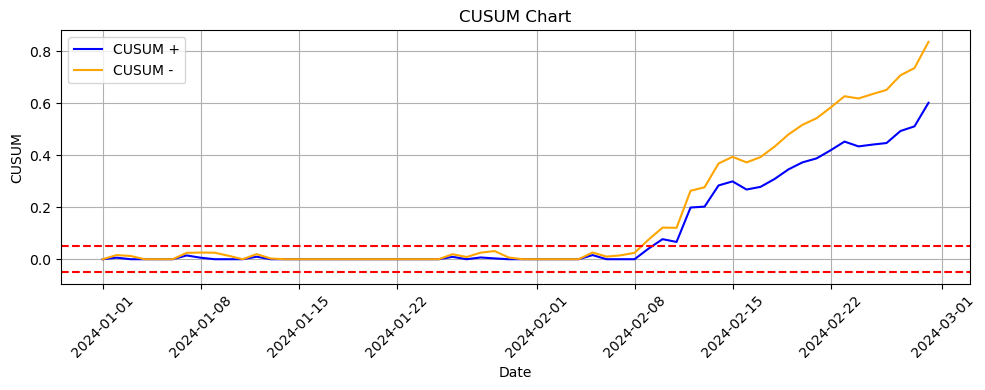

In [ ]:
target=df['Defect_rate'].mean() #base line(center line)
k=0.005 #Reference value(senisitivity threshold)
h=0.05 #Decision threshold

#Intitialize lists
cusum_pos=[0]
cusum_neg=[0]

#Calculate CUSUM values
for i in range(1,len(df)):
  p_i=df.loc[i,'Defect_rate'] #Everyday defect rate
  s_pos=max(0,cusum_pos[-1]+(p_i-target-k))
  s_neg=max(0,cusum_neg[-1]+(p_i-target+k))
  cusum_pos.append(s_pos)
  cusum_neg.append(s_neg)
df['CUSUM_pos']=cusum_pos
df['CUSUM_neg']=cusum_neg
# Plot CUSUM
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['CUSUM_pos'], label='CUSUM +', color='blue')
plt.plot(df['date'], df['CUSUM_neg'], label='CUSUM -', color='orange')
plt.axhline(h, color='red', linestyle='--')
plt.axhline(-h, color='red', linestyle='--')

plt.title('CUSUM Chart')
plt.xlabel('Date')
plt.ylabel('CUSUM')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This CUSUM chart shows both the positive (blue) and negative (orange) cumulative sums increasing steadily after early February. Although the lines stay within the control limits (red dashed lines), their continuous upward movement signals a gradual shift in the process. This means the defect rate is likely increasing consistently over time, even though it hasn’t yet triggered a traditional p-chart alert. So, the process may still appear "in control," but CUSUM reveals an early warning that something is slowly going wrong and needs attention.




## EWMA Chart
An EWMA chart (Exponentially Weighted Moving Average) is used to track small, gradual changes in a process by giving more importance to recent data and less to older data. It helps detect subtle trends early by smoothing out random noise, so it’s easier to see if things are getting better or worse. Unlike p-charts that detect big jumps or CUSUM charts that build up small changes, EWMA gently shows if the process is drifting. It's especially helpful in projects like tracking defect rates, where even small, slow increases matter. If defects slowly rise over days, an EWMA chart will show a smooth upward curve, giving you a clear early warning.


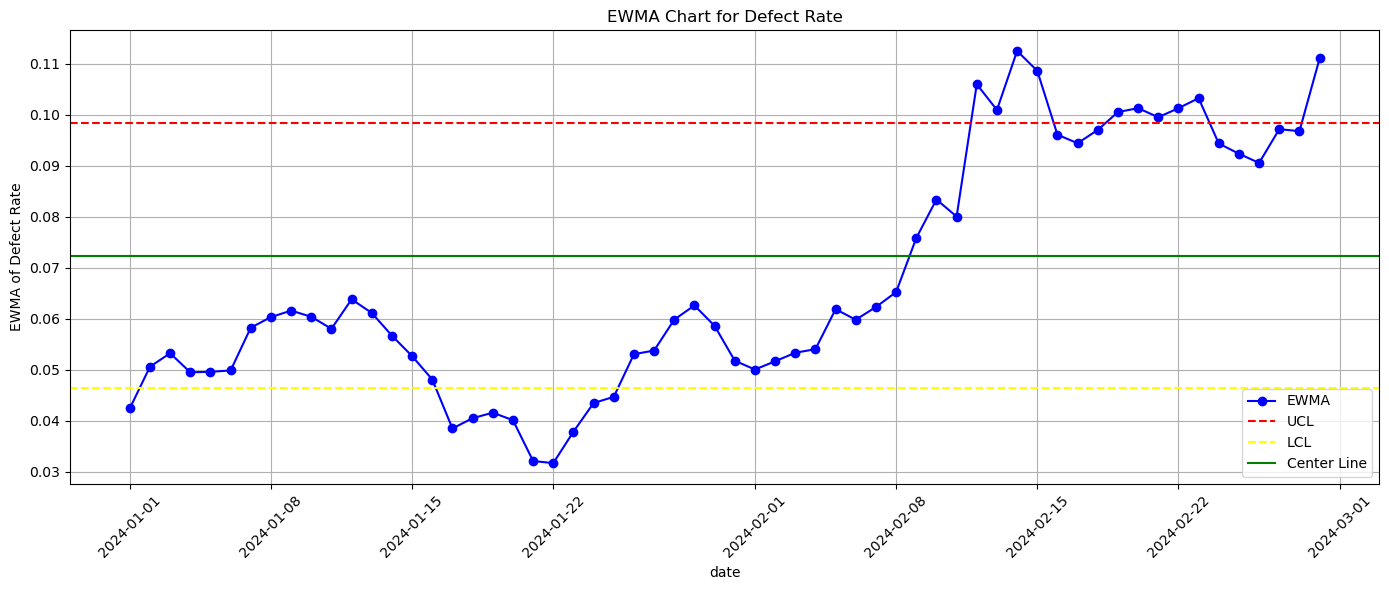

In [ ]:
# EWMA calculation
lam = 0.2
l = 3
df['EMA'] = 0.0
df.loc[0, 'EMA'] = df.loc[0, 'Defect_rate']

for i in range(1, len(df)):
    df.loc[i, 'EMA'] = lam * df.loc[i, 'Defect_rate'] + (1 - lam) * df.loc[i - 1, 'EMA']

# Control limits calculation
p_bar = df['Defect_rate'].mean()
avg_n = df['sample_size'].mean()
sigma = np.sqrt((p_bar * (1 - p_bar)) / avg_n)

df['UCL'] = p_bar + l * sigma * np.sqrt(lam / (2 - lam))
df['LCL'] = p_bar - l * sigma * np.sqrt(lam / (2 - lam))
df['CL'] = p_bar

# Plotting the EWMA chart
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['EMA'], marker='o', label='EWMA', color='blue')
plt.axhline(df['UCL'][0], color='red', linestyle='--', label='UCL')
plt.axhline(df['LCL'][0], color='yellow', linestyle='--', label='LCL')
plt.axhline(df['CL'][0], color='green', linestyle='-', label='Center Line')

plt.title('EWMA Chart for Defect Rate')
plt.xlabel('date')
plt.ylabel('EWMA of Defect Rate')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The EWMA chart shows that the defect rate remained fairly stable and low during early January, but started gradually increasing from early February onward. Around mid-February, the EWMA line crossed the upper control limit (UCL), signaling a statistically significant increase in defects. This means the process may no longer be in control, and corrective actions should be considered. The steady upward trend and control limit breach suggest that a real shift in the process has occurred rather than just random variation.


---



## KPI(Knowledge process indicator) Dashboard with matplotlib

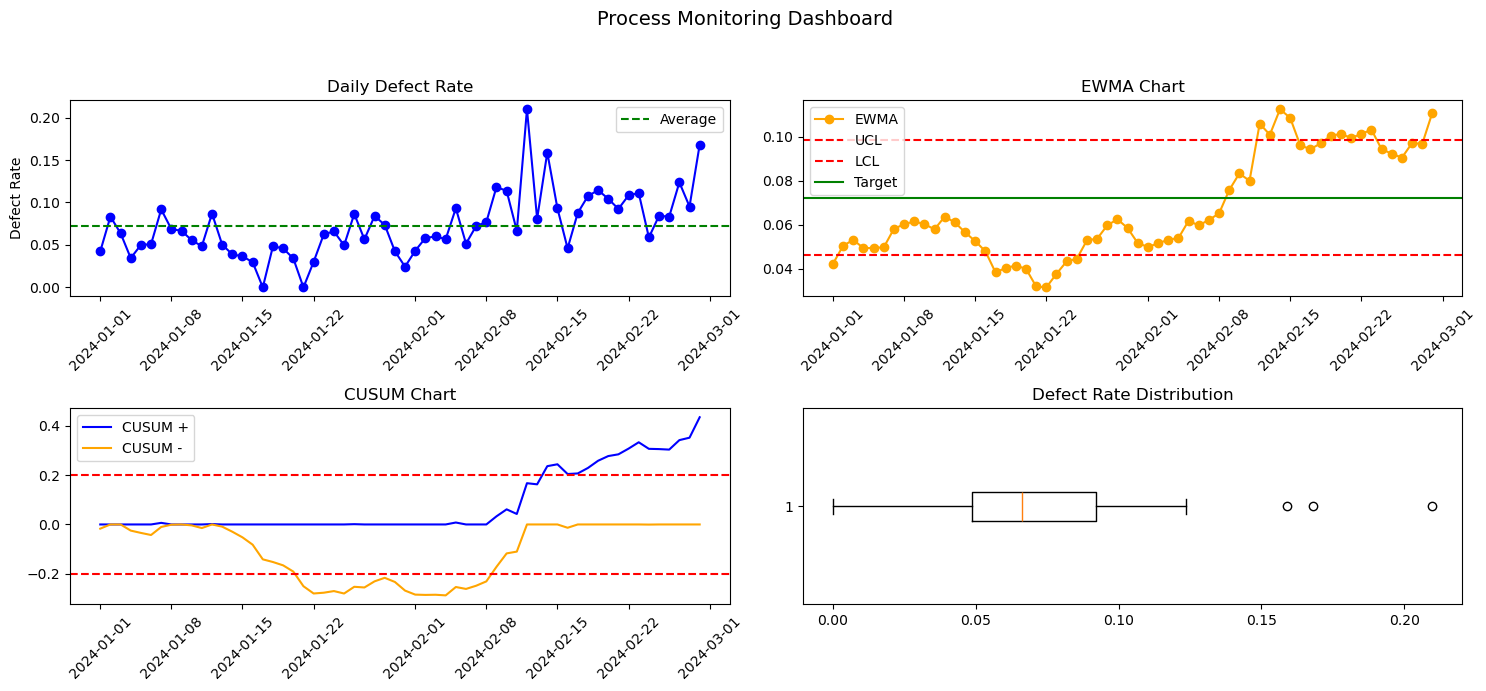

 Summary KPIs:
- Average Defect Rate: 0.0724
- Max Defect Rate:     0.2099
- Min Defect Rate:     0.0000
- Out-of-control Days (CUSUM): 35
- Days Monitored:      60

 Note: Control limits for Daily Chart use p̄ ± 3σ (based on overall avg and daily sample size - calculated earlier). EWMA λ = 0.2.


In [ ]:
# CUSUM Calculation
# Target defect rate (center line)
target_p = p_bar

# Reference value k (usually half the allowance delta, delta typically around 1 sigma)
# A common choice is k = 0.5 * sigma
k = 0.5 * sigma

# Initialize CUSUM columns
df['CUSUM_Pos'] = 0.0
df['CUSUM_Neg'] = 0.0

# Calculate CUSUM values
for i in range(len(df)):
    # Deviation from target
    deviation = df.loc[i, 'Defect_rate'] - target_p

    # Positive CUSUM (detects increases)
    if i == 0:
        df.loc[i, 'CUSUM_Pos'] = max(0, deviation - k)
    else:
        df.loc[i, 'CUSUM_Pos'] = max(0, df.loc[i - 1, 'CUSUM_Pos'] + deviation - k)

    # Negative CUSUM (detects decreases)
    if i == 0:
        df.loc[i, 'CUSUM_Neg'] = min(0, deviation + k)
    else:
        df.loc[i, 'CUSUM_Neg'] = min(0, df.loc[i - 1, 'CUSUM_Neg'] + deviation + k)

# Now, recalculate out-of-control days using CUSUM with the threshold h
h = 0.2  # Decision interval threshold
out_of_control_days = df[(df['CUSUM_Pos'] > h) | (df['CUSUM_Neg'] < -h)].shape[0]

# The rest of the plotting code remains the same.
# KPI Calculations
average_defect_rate = df['Defect_rate'].mean()
max_defect_rate = df['Defect_rate'].max()
min_defect_rate = df['Defect_rate'].min()

# Days monitored
days_monitored = len(df)

# Plot setup
fig, axs = plt.subplots(2, 2, figsize=(15, 7))
fig.suptitle('Process Monitoring Dashboard', fontsize=14)

# --- Plot 1: Daily Defect Rate ---
axs[0, 0].plot(df['date'], df['Defect_rate'], marker='o', color='blue')
axs[0, 0].axhline(p_bar, color='green', linestyle='--', label='Average')
axs[0, 0].set_title('Daily Defect Rate')
axs[0, 0].set_ylabel('Defect Rate')
axs[0, 0].legend()
axs[0, 0].tick_params(axis='x', rotation=45)

# --- Plot 2: EWMA Chart ---
axs[0, 1].plot(df['date'], df['EMA'], marker='o', color='orange', label='EWMA')
axs[0, 1].axhline(df['UCL'][0], color='red', linestyle='--', label='UCL')
axs[0, 1].axhline(df['LCL'][0], color='red', linestyle='--', label='LCL')
axs[0, 1].axhline(p_bar, color='green', linestyle='-', label='Target')
axs[0, 1].set_title('EWMA Chart')
axs[0, 1].legend()
axs[0, 1].tick_params(axis='x', rotation=45)

# --- Plot 3: CUSUM Chart ---
axs[1, 0].plot(df['date'], df['CUSUM_Pos'], label='CUSUM +', color='blue')
axs[1, 0].plot(df['date'], df['CUSUM_Neg'], label='CUSUM -', color='orange')
axs[1, 0].axhline(h, color='red', linestyle='--')
axs[1, 0].axhline(-h, color='red', linestyle='--')
axs[1, 0].set_title('CUSUM Chart')
axs[1, 0].legend()
axs[1, 0].tick_params(axis='x', rotation=45)

# --- Plot 4: Boxplot ---
axs[1, 1].boxplot(df['Defect_rate'], vert=False)
axs[1, 1].set_title('Defect Rate Distribution')

# Layout adjustments
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Print KPIs
print(" Summary KPIs:")
print(f"- Average Defect Rate: {average_defect_rate:.4f}")
print(f"- Max Defect Rate:     {max_defect_rate:.4f}")
print(f"- Min Defect Rate:     {min_defect_rate:.4f}")
print(f"- Out-of-control Days (CUSUM): {out_of_control_days}")
print(f"- Days Monitored:      {days_monitored}")
print()
print(" Note: Control limits for Daily Chart use p̄ ± 3σ (based on overall avg and daily sample size - calculated earlier). EWMA λ = 0.2.")

# Conclusion:
The analysis used p-chart,NEW, and EWMA control charts to monitor defect rates in a manufacturing process. While the process initially appeared stable, all charts detected a clear upward trend in defects starting in early February:

- P-chart showed a steady increase in defects with statistical significance.

- C detected small, consistent shifts that crossed control limits, signaling ongoing deterioration.

- EWMA highlighted a gradual rise in defects, ultimately breaching control limits.

# Final Conclusion:
All methods confirmed that the process is out of control, indicating a decline in manufacturing quality and the need for immediate corrective action.